# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.TransferCFM import StandardCFM as TransferCFM
from memflow.ttH.models.Transfusion import StandardCFM as Transfusion
from memflow.ttH.models.ParallelTransfusion import StandardCFM as ParallelTransfusion

from models.utils2 import *
from models.utils import load_samples
from models.callbacks import CFMSamplingCallback, SamplingCallback, BiasCallback

from transfer_flow.transfer_flow_model import *
from transfer_flow.custom_flows import *

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-02-28 14:42:52.767918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 14:42:52.767981: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 14:42:52.767990: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn  

# Reco dataset

In [4]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [5]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt

# Combined dataset

In [6]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : True
Zs   

In [7]:
TransferCFM_model = TransferCFM.load_from_checkpoint(checkpoint_path="TransferCFM_checkpoints/model_epoch_500.ckpt")
TransferCFM_model.to(accelerator)
TransferCFM_model.eval()

No hard attention mask provided; will use existence mask only.


/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fea

In [8]:
ParallelTransfusion_model = ParallelTransfusion.load_from_checkpoint(checkpoint_path="parallel_transfusion_checkpoints/model_epoch_500.ckpt")
ParallelTransfusion_model.to(accelerator)
ParallelTransfusion_model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64
('pt', 'eta', 'phi', 'mass')
('pt', 'phi')


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

In [9]:
transfermer_model = TransferFlow.load_from_checkpoint(
    checkpoint_path="TransferFlow_checkpoints/model_epoch_500.ckpt",
    encoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.hard_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    decoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.reco_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    transformer=Transformer(
        d_model=64,
        encoder_layers=6,
        decoder_layers=8,
        nhead=8,
        dim_feedforward=256,
        activation=nn.GELU,
        encoder_mask_attn=None,
        decoder_mask_attn=combined_dataset.reco_dataset.attention_mask,
        use_null_token=True,
        dropout=0.0,
    ),
    flow=KinematicFlow(
        d_model=64,
        flow_mode='global',
        flow_features=[
            ['pt', 'eta', 'phi', 'mass'],  # jets
            ['pt', 'phi'],  # met
        ],
        flow_classes={
            'pt': zuko.flows.NSF,
            'eta': UniformNSF,
            'phi': UniformNCSF,
            'mass': zuko.flows.NSF,
        },
        flow_common_args={
            'bins': 16,
            'transforms': 5,
            'randperm': True,
            'passes': None,
            'hidden_features': [256] * 3,
        },
        flow_specific_args={
            'eta': {'bound': 1.0},
            'phi': {'bound': math.pi},
        },
    ),
)
transfermer_model.to(accelerator)
transfermer_model.eval()

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder_embeddings'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transformer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10

TransferFlow(
  (encoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0-2): 3 x MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (decoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0): MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
      (1): MLP(
        (layers): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (transformer): Transformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layer

In [51]:
gen_data1 = load_samples('Transfermer_samples_full.pt')
gen_data2 = load_samples('PT_samples_full.pt')
gen_data3 = load_samples('TransferCFM_samples_full.pt')

Samples loaded from saved_samples/Transfermer_samples_full.pt
Samples loaded from saved_samples/PT_samples_full.pt
Samples loaded from saved_samples/TransferCFM_samples_full.pt


In [11]:
train_frac = 0.8
indices = torch.arange(len(combined_dataset))
sep = int(train_frac*len(combined_dataset))
valid_indices = indices[sep:]
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,valid_indices)
print (f'Dataset : validation {len(combined_dataset_valid)}')

# Use a DataLoader with batch_size=10 for testing (change as needed)
loader = DataLoader(
    combined_dataset_valid,
    batch_size=20000,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
batch = next(iter(loader))
batch = CFMSamplingCallback.move_batch_to_device(batch, TransferCFM_model.device)
print(f'Number of batches: {len(loader)}')
print(f"batch_size: {len(batch['hard']['data'][0])}")
# Get the reco mask for the same index.
real_data = batch["reco"]["data"]
real_mask = batch["reco"]["mask"]

Dataset : validation 18364


Number of batches: 1
batch_size: 18364


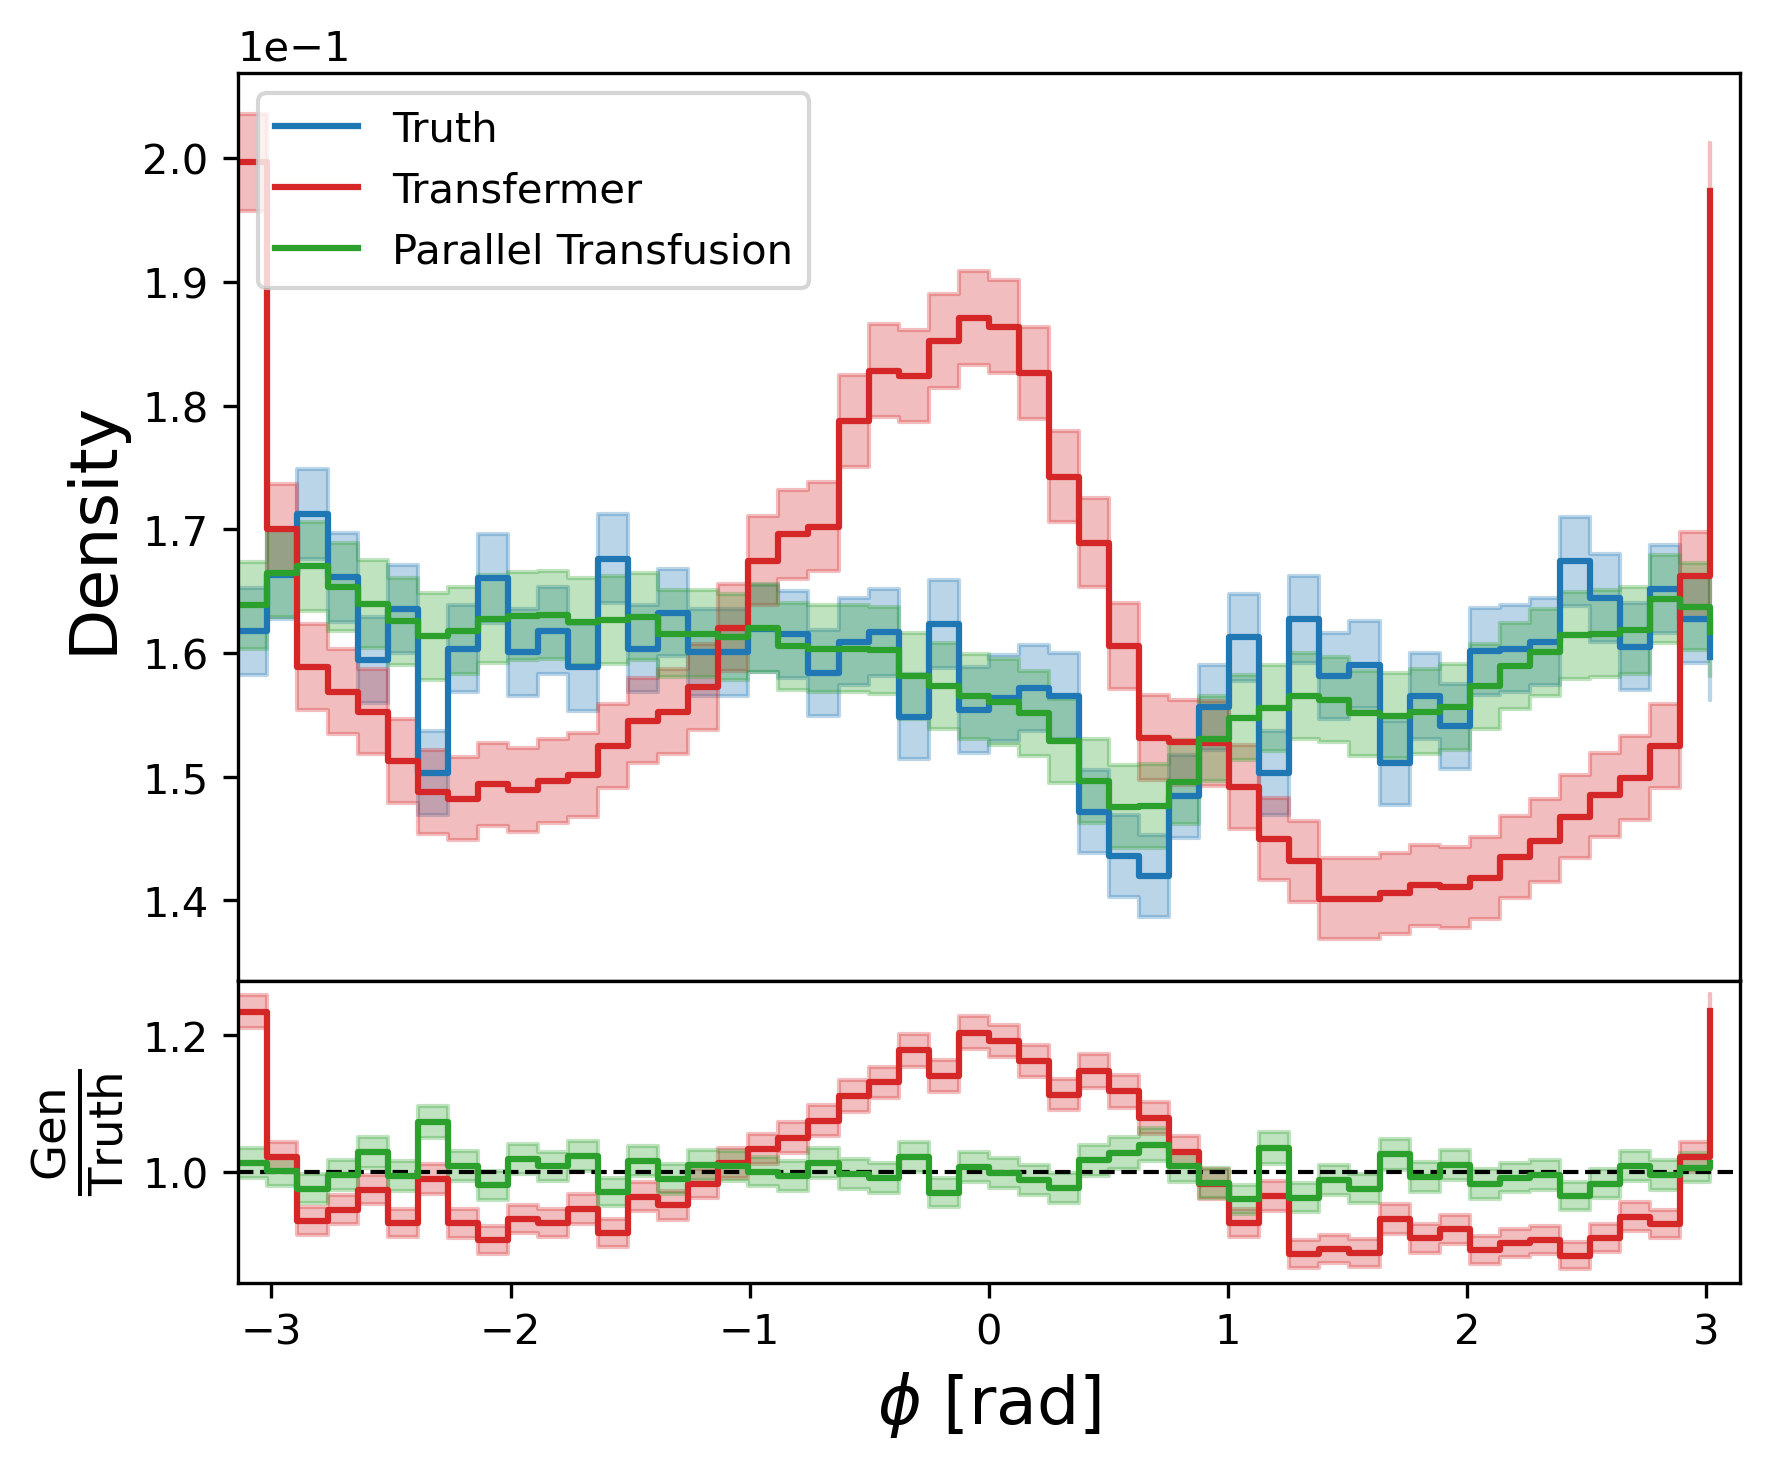

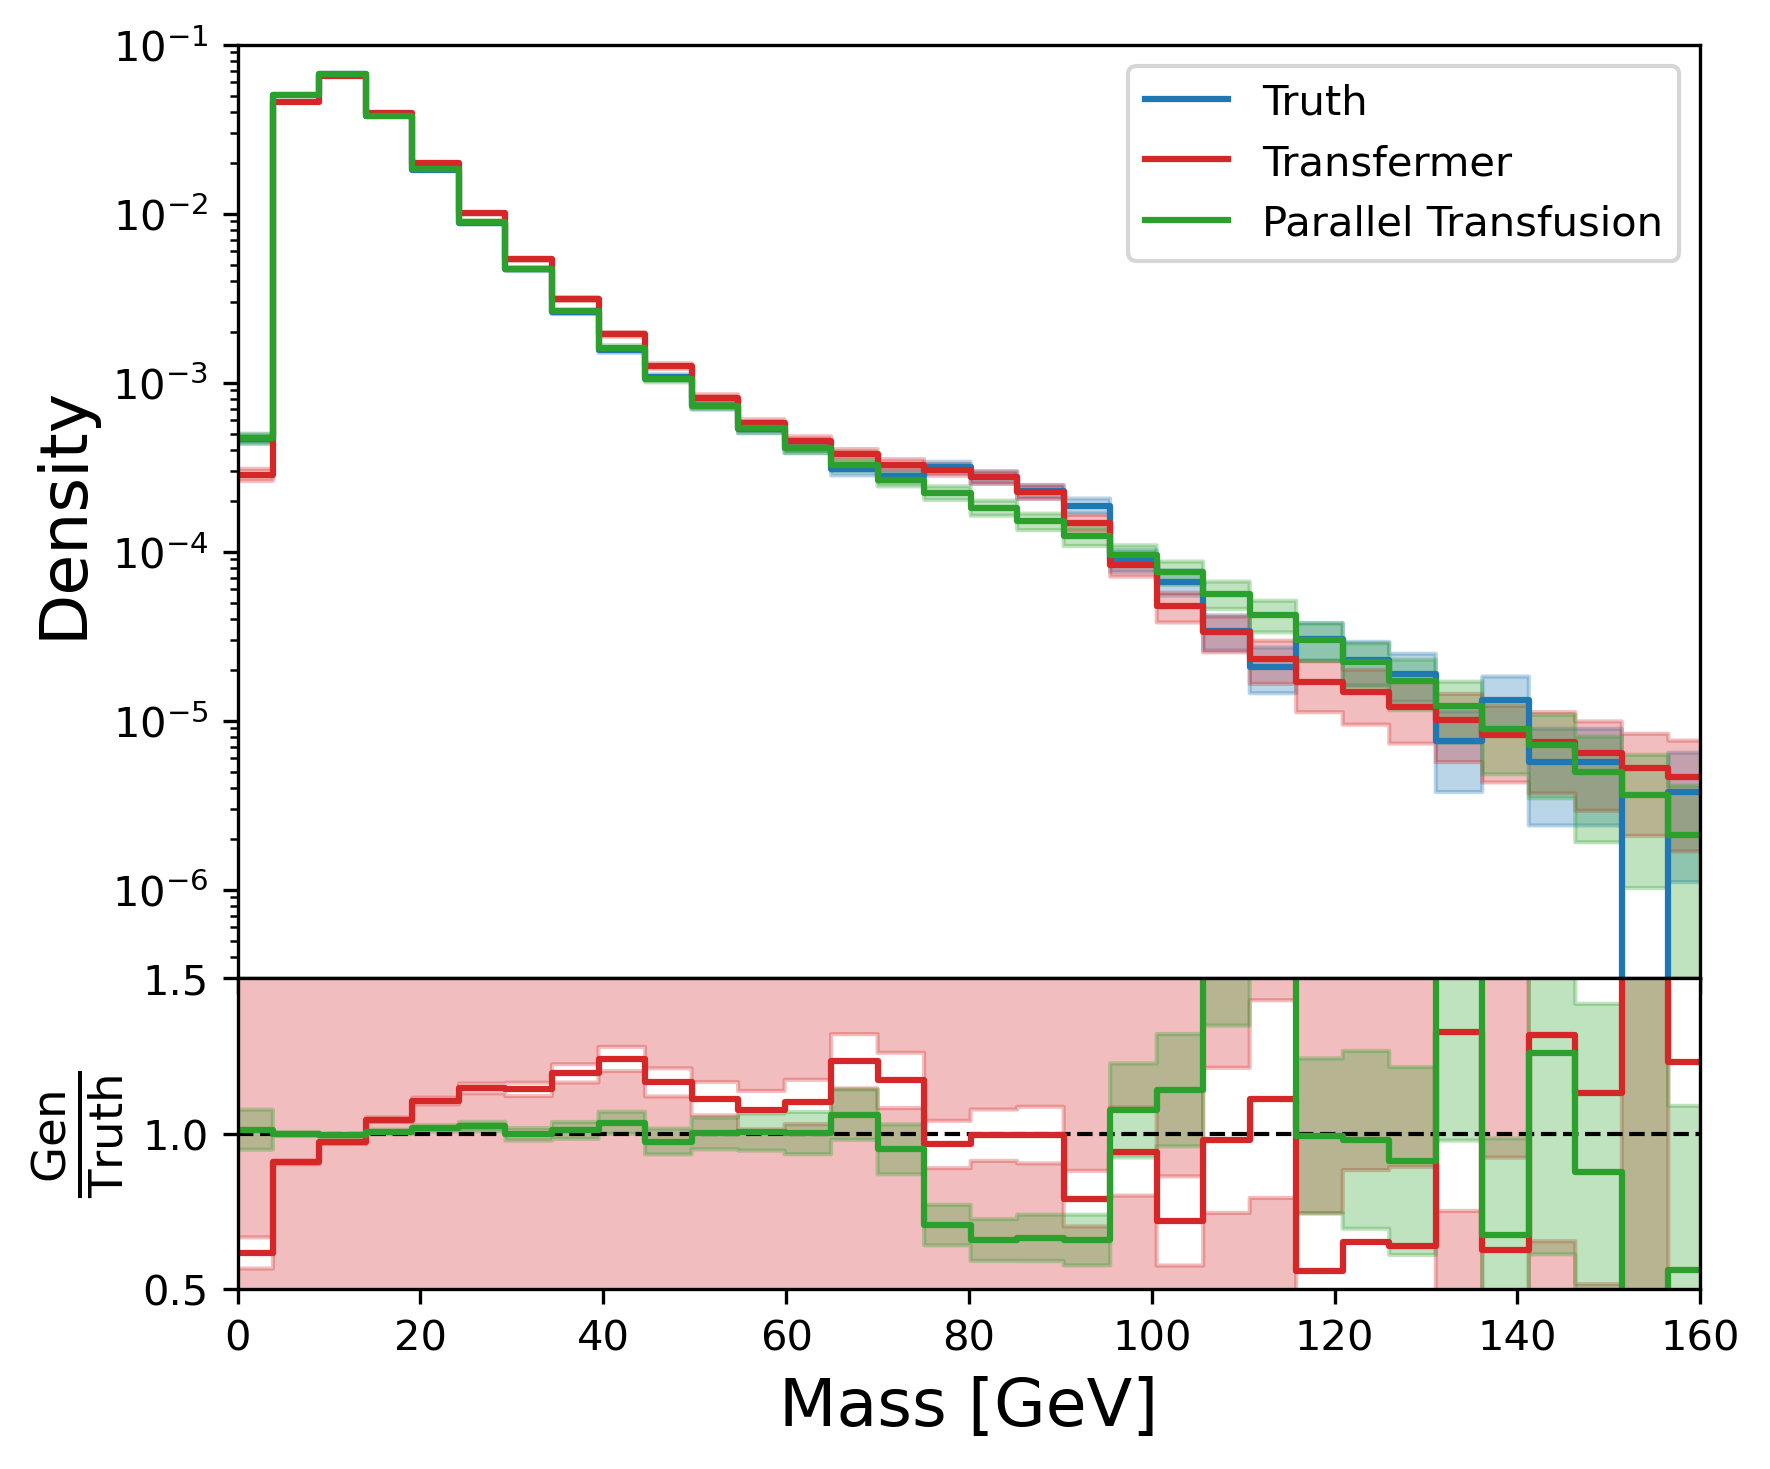

In [12]:
fd = FeatureDistributions(TransferCFM_model, preprocessing=combined_dataset.reco_dataset.preprocessing, real_mask=real_mask)
#fd.compare_distributions(real_data, gen_data1, ptype_idx=0, feat_idx=0, nbins=50, feat_name="pT")
# MET
#fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=1, feat_idx=0, nbins=500, feat_name=r'$p_T$ [GeV]')
#fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=1, feat_idx=1, nbins=50, feat_name=r'$\phi$ [rad]')
# Jets
#fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=0, feat_idx=0, nbins=1000, feat_name=r'$p_T$ [GeV]')
#fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=0, feat_idx=1, nbins=50, feat_name=r'$\eta$')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=0, feat_idx=2, nbins=50, feat_name=r'$\phi$ [rad]')
fd.compare_distributions_multiple(real_data, gen_data1, gen_data2, ptype_idx=0, feat_idx=3, nbins=400, feat_name=r'Mass [GeV]')

Truth values: Min=30.4725284576416, Max=1767.6405029296875, Size=(18364,)
Transfermer values: Min=28.077022552490234, Max=39728.984375, Size=(1836400,)
Parallel Transfusion values: Min=30.176128387451172, Max=33889.62890625, Size=(1836400,)


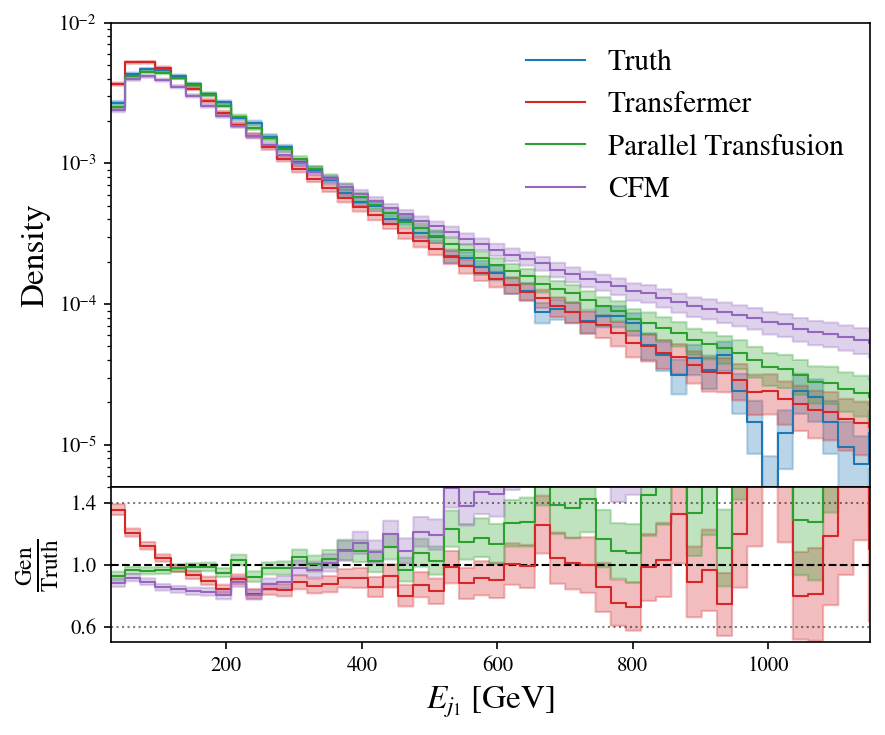

In [ ]:
# Define feature index mapping (for jets)
feat_idx_map = {"pt": 0, "eta": 1, "phi": 2, "mass": 3}

# Initialize the HighLevelDistributionsVector class
high_level_dists = HighLevelDistributions(
    model = ParallelTransfusion_model,
    preprocessing = combined_dataset.reco_dataset.preprocessing,
    feat_idx_map = feat_idx_map,
    real_data = real_data,
    real_mask = real_mask,
    gen_data = gen_data1,
    gen_data2 = gen_data2,
    gen_data3 = gen_data3,
    jet_ordering = "btag"  # Change to "pt" if you want to reorder all jets by pT
)


# Now you can plot individual observables:
high_level_dists.plot_E_j1()
high_level_dists.plot_pT_j1()
high_level_dists.plot_dphi_j1j2()   # Uses built-in .deltaphi
high_level_dists.plot_dR_j1j2()     # Uses built-in .deltaR
high_level_dists.plot_HT()          # Scalar sum of pT
high_level_dists.plot_dR_met_jj()   # Uses vector sum of MET + dijet
high_level_dists.plot_min_mass_jj() # Uses invariant mass calculation

# # Or plot all distributions in one go:
# high_level_dists.plot_all()
